<a href="https://colab.research.google.com/github/rbflakt/streamlit_1/blob/main/refinement(AMR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [ ]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList() # Initialise empty list for layers.
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1])) # Creates fully connected layers for user defined layer size.
        self.activation = nn.Tanh() # Change activation function depending on use case. Another commonly used one is ReLU.

    def forward(self, x): # Defines forward pass from one layer to the next.
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x)) # Apply linear transformation, then activation function to the input at each layer
        x = self.layers[-1](x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = PINN([2, 5, 5, 5, 5, 5, 1]).to(device) # Change as needed.

In [ ]:
# 처음부터 requires_grad=True로 설정
collocation_points = torch.rand(10000, 2, requires_grad=True).to(device)

def refine_collocation_points(collocation_points, model, threshold_loss):
    predictions = model(collocation_points)
    u = predictions[:, 0]

    grads = torch.autograd.grad(outputs=u, inputs=collocation_points,
                                grad_outputs=torch.ones_like(u),
                                create_graph=True)[0]
    u_x = grads[:, 0]
    u_y = grads[:, 1]

    grads2 = torch.autograd.grad(outputs=u_x, inputs=collocation_points,
                                 grad_outputs=torch.ones_like(u_x),
                                 create_graph=True)[0]
    u_xx = grads2[:, 0]

    grads3 = torch.autograd.grad(outputs=u_y, inputs=collocation_points,
                                 grad_outputs=torch.ones_like(u_y),
                                 create_graph=True)[0]
    u_yy = grads3[:, 1]
    f = torch.sin(np.pi * collocation_points[:, 0]) * torch.sin(np.pi * collocation_points[:, 1])
    residuals = u_xx + u_yy + f
    loss_pde = residuals**2

    high_loss_points = collocation_points[loss_pde > threshold_loss]
    if high_loss_points.shape[0] > 0:
        new_points = high_loss_points + 0.5 * (torch.rand_like(high_loss_points) - 0.5)
        new_points = new_points.clone().detach().requires_grad_(True)
        collocation_points = torch.cat((collocation_points, new_points), dim=0)

    return collocation_points

def compute_boundary_condition_loss(boundary_points, boundary_values):
    predictions = model(boundary_points)
    loss_bc = torch.mean((predictions - boundary_values)**2)
    return loss_bc

def compute_pde_residual_loss(collocation_points):
    # collocation_points는 이미 requires_grad=True로 생성되었으므로 다시 설정할 필요가 없습니다.
    predictions = model(collocation_points)
    u = predictions[:, 0]

    grads = torch.autograd.grad(outputs=u, inputs=collocation_points,
                                grad_outputs=torch.ones_like(u),
                                create_graph=True)[0]
    u_x = grads[:, 0]
    u_y = grads[:, 1]

    grads2 = torch.autograd.grad(outputs=u_x, inputs=collocation_points,
                                 grad_outputs=torch.ones_like(u_x),
                                 create_graph=True)[0]
    u_xx = grads2[:, 0]

    grads3 = torch.autograd.grad(outputs=u_y, inputs=collocation_points,
                                 grad_outputs=torch.ones_like(u_y),
                                 create_graph=True)[0]
    u_yy = grads3[:, 1]
    f = torch.sin(np.pi * collocation_points[:, 0]) * torch.sin(np.pi * collocation_points[:, 1])
    residuals = u_xx + u_yy + f
    loss_pde = torch.mean(residuals**2)
    return loss_pde

# 전체 손실 함수
def total_loss(boundary_points, boundary_values, collocation_points):
    loss_bc = compute_boundary_condition_loss(boundary_points, boundary_values)
    loss_pde = compute_pde_residual_loss(collocation_points)

    # 손실 함수 가중치 설정
    lambda_bc = 1
    lambda_pde = 1e-4

    return lambda_bc * loss_bc + lambda_pde * loss_pde

def adaptive_mesh_refinement(collocation_points, loss_pde, threshold=1e-5):
    high_loss_points = collocation_points[loss_pde > threshold]
    new_points = []
    for point in high_loss_points:
        neighbors = collocation_points[torch.norm(collocation_points - point, dim=1) < 0.1]
        if len(neighbors) > 0:
            mean_point = neighbors.mean(dim=0)
            new_points.append((point + mean_point) / 2)
    if new_points:
        new_points = torch.stack(new_points)
        collocation_points = torch.cat((collocation_points, new_points), dim=0)
    return collocation_points

# 경계 조건 설정
x_boundary = torch.cat((torch.zeros(100, 1), torch.ones(100, 1), torch.linspace(0, 1, 100).view(-1, 1), torch.linspace(0, 1, 100).view(-1, 1)), dim=0).to(device)
y_boundary = torch.cat((torch.linspace(0, 1, 100).view(-1, 1), torch.linspace(0, 1, 100).view(-1, 1), torch.zeros(100, 1), torch.ones(100, 1)), dim=0).to(device)
boundary_points = torch.cat((x_boundary, y_boundary), dim=1).to(device)
boundary_values = torch.zeros(boundary_points.shape[0], 1).to(device)

# 콜로케이션 포인트 설정 - requires_grad=True
collocation_points = torch.rand(10000, 2, requires_grad=True).to(device)

In [ ]:
# 최적화기 설정
optimizer = optim.Adam(model.parameters(), lr=0.0001)
best_loss = float('inf')
best_model_path = 'best_model_poisson_2d.pth'
threshold_loss = 1e-5


def train_model(num_epochs, boundary_points, boundary_values, collocation_points, threshold_loss):
    global best_loss
    start_time=time.time()
    continue_training = True

    while continue_training:
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            loss = total_loss(boundary_points, boundary_values, collocation_points)
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}')

            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), best_model_path)

            if loss.item() <= threshold_loss:
                end_time=time.time()
                total_time=end_time-start_time
                print(f'Threshold loss reached: {loss.item()} at epoch {epoch} and total time is {total_time:.2f}')
                continue_training = False
                break

        if continue_training:
            # 로스가 임계값 이하로 떨어지지 않았을 경우, 그리드 세분화 및 재학습
            collocation_points = refine_collocation_points(collocation_points, model, threshold_loss)
            print("Refining the mesh and continuing training...")
            # 세분화된 그리드로 다시 100 에폭마다 학습 진행
            for refined_epoch in range(num_epochs):
                optimizer.zero_grad()
                loss = total_loss(boundary_points, boundary_values, collocation_points)
                loss.backward()
                optimizer.step()

                if refined_epoch % 100 == 0:
                    print(f'Refined Epoch {refined_epoch}, Loss: {loss.item()}')

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    torch.save(model.state_dict(), best_model_path)

                if loss.item() <= threshold_loss:
                    end_time=time.time()
                    total_time=end_time-start_time
                    print(f'Threshold loss reached: {loss.item()} at refined epoch {refined_epoch} and total time is {total_time:.2f} seconds')
                    continue_training = False
                    break
# 모델 학습
train_model(9000, boundary_points, boundary_values, collocation_points, threshold_loss)

Epoch 0, Loss: 1.0026191375800408e-05
Threshold loss reached: 9.997484085033648e-06 at epoch 43 and total time is 0.94


[[-0.00471136 -0.00416291 -0.00363642 ...  0.00066473  0.00081502
   0.00096788]
 [-0.00439234 -0.00381945 -0.00326821 ...  0.0006219   0.00075172
   0.00088416]
 [-0.00407903 -0.00348207 -0.0029065  ...  0.00058122  0.0006903
   0.00080235]
 ...
 [-0.00189134 -0.00169119 -0.00149947 ... -0.00361677 -0.00416707
  -0.00473741]
 [-0.00195369 -0.00176714 -0.00158913 ... -0.00417054 -0.00470005
  -0.00524975]
 [-0.00201513 -0.00184207 -0.00167772 ... -0.004746   -0.00525461
  -0.00578348]]


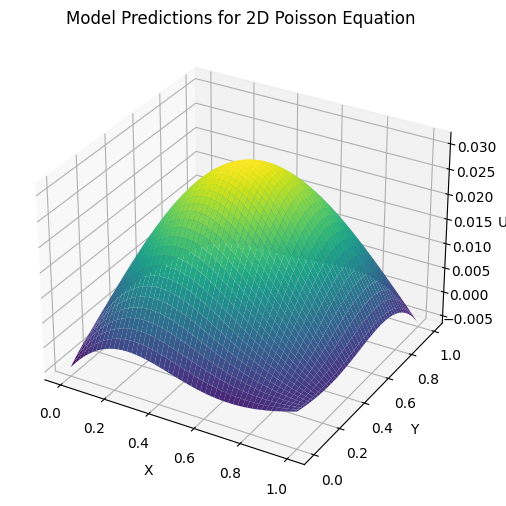

In [ ]:
# 결과 예측 및 시각화
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
XY = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

XY_tensor = torch.tensor(XY, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    pred = model(XY_tensor).cpu().numpy()

U_pred = pred.reshape(X.shape)
print(U_pred) #!각 좌표마다의 예측 값을 알기 위한 코드 100x100행렬

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U_pred, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('U')
ax.set_title('Model Predictions for 2D Poisson Equation')

plt.show()

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.09980807e-05 1.01944811e-04 ... 1.01944811e-04
  5.09980807e-05 1.96844324e-19]
 [0.00000000e+00 1.01944811e-04 2.03786972e-04 ... 2.03786972e-04
  1.01944811e-04 3.93490443e-19]
 ...
 [0.00000000e+00 1.01944811e-04 2.03786972e-04 ... 2.03786972e-04
  1.01944811e-04 3.93490443e-19]
 [0.00000000e+00 5.09980807e-05 1.01944811e-04 ... 1.01944811e-04
  5.09980807e-05 1.96844324e-19]
 [0.00000000e+00 1.96844324e-19 3.93490443e-19 ... 3.93490443e-19
  1.96844324e-19 7.59787182e-34]]


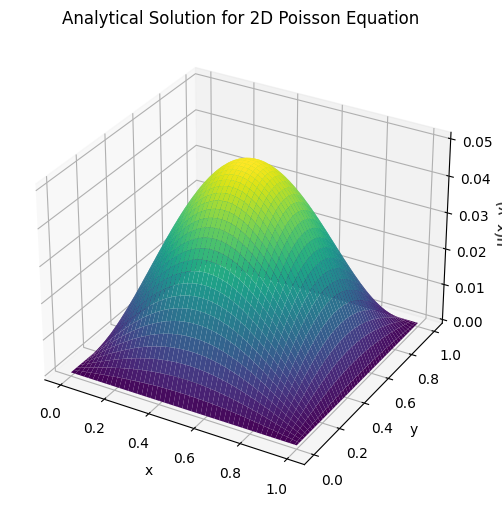

In [ ]:
# 해석적 해와 비교
def analytical_solution(x, y):
    return (1/(2*(np.pi**2)))*np.sin(np.pi * x) * np.sin(np.pi * y)

u_anal = analytical_solution(X, Y)

print(u_anal) #!각 좌표마다의 실제 값을 알기 위한 코드 100x100행렬

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u_anal, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x, y)')
ax.set_title('Analytical Solution for 2D Poisson Equation')

plt.show()

In [ ]:
# 1. 초기 그리드를 설정하는 함수
def create_initial_grid(x_min, x_max, y_min, y_max, num_points_x, num_points_y):
    x = np.linspace(x_min, x_max, num_points_x)
    y = np.linspace(y_min, y_max, num_points_y)
    X, Y = np.meshgrid(x, y)
    return X, Y

# 2. 실제 해 (정확한 해) 또는 비교할 함수를 정의
def Phi(X, Y):
    return np.sin(np.pi * X) * np.sin(np.pi * Y)

# 3. 경계점에서의 손실을 계산하는 함수
def calculate_boundary_loss(X, Y, model, phi):
    # Use model() for prediction in PyTorch
    input_tensor = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32).to(device)
    U_pred = model(input_tensor).detach().numpy().ravel()  # Detach from graph, move to CPU, convert to NumPy
    U_true = Phi(X,Y).ravel()
    loss = np.mean(np.square(U_pred - U_true))
    return loss

# 4. 손실이 큰 그리드를 세분화하는 함수
def refine_grid(X, Y, loss_threshold, num_points_x, num_points_y):
    loss = calculate_boundary_loss(X, Y, model, phi)
    if loss > loss_threshold:
        # 손실이 큰 영역을 세분화
        mid_x = (X[0, :-1] + X[0, 1:]) / 2
        mid_y = (Y[:-1, 0] + Y[1:, 0]) / 2
        new_x = np.sort(np.unique(np.concatenate([X[0], mid_x])))
        new_y = np.sort(np.unique(np.concatenate([Y[:, 0], mid_y])))
        return np.meshgrid(new_x, new_y)
    return X, Y

# 5. 신경망 모델을 학습시키는 함수
def train_model(X, Y, model, epochs, batch_size):
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            U_pred = model(np.stack([X.ravel(), Y.ravel()], axis=-1))
            U_true = Phi(X,Y).ravel()
            loss = tf.reduce_mean(tf.square(U_pred - U_true))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# 6. 메인 함수: 초기화 및 실행
def main():
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    num_points_x = num_points_y = 10  # 초기 그리드 크기
    phi = np.pi  # phi의 예시 값
    loss_threshold = 0.01  # 손실 임계값
    max_iterations = 3  # 최대 반복 횟수
    iteration = 0  # 초기 반복 횟수

    # 초기 그리드 생성
    X, Y = create_initial_grid(x_min, x_max, y_min, y_max, num_points_x, num_points_y)

    # 간단한 신경망 모델 초기화
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, activation='tanh', input_shape=(2,)),
        tf.keras.layers.Dense(20, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])

    # while 루프를 사용하여 그리드 세분화 및 학습 반복
    while iteration < max_iterations:
     print(f"Iteration {iteration + 1}/{max_iterations}")
     X, Y = refine_grid(X, Y, loss_threshold, num_points_x, num_points_y)
     train_model(X, Y, model, epochs=1000, batch_size=32)
     iteration += 1


  # 최종 평가
    final_loss = calculate_boundary_loss(X, Y, model, phi)
    print(f'Final Loss: {final_loss}')

    # 결과 시각화
    U_pred = model.predict(np.stack([X.ravel(), Y.ravel()], axis=-1)).reshape(X.shape)
    plt.contourf(X, Y, U_pred, levels=50)
    plt.colorbar()
    plt.title("Predicted Solution")
    plt.show()

if __name__ == "__main__":
    main()


Iteration 1/3
Epoch 0, Loss: 0.17144116759300232
Epoch 100, Loss: 0.0935560092329979
Epoch 200, Loss: 0.09343350678682327
Epoch 300, Loss: 0.09343158453702927
Epoch 400, Loss: 0.09342947602272034
Epoch 500, Loss: 0.09342730790376663
Epoch 600, Loss: 0.09342517703771591
Epoch 700, Loss: 0.09342312067747116
Epoch 800, Loss: 0.09342118352651596
Epoch 900, Loss: 0.09341937303543091
Iteration 2/3
Epoch 0, Loss: 0.09029249101877213
Epoch 100, Loss: 0.08984784036874771
Epoch 200, Loss: 0.0898447036743164
Epoch 300, Loss: 0.08984225243330002
Epoch 400, Loss: 0.08984056115150452
Epoch 500, Loss: 0.08983943611383438
Epoch 600, Loss: 0.08983869850635529
Epoch 700, Loss: 0.08983821421861649
Epoch 800, Loss: 0.08983790129423141
Epoch 900, Loss: 0.0898376852273941
Iteration 3/3
Epoch 0, Loss: 0.08797746151685715
Epoch 100, Loss: 0.08785801380872726
Epoch 200, Loss: 0.08785797655582428
Epoch 300, Loss: 0.0878579244017601
Epoch 400, Loss: 0.08785790205001831
Epoch 500, Loss: 0.08785787224769592
Epoch 

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'detach'